In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from collections import Counter
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from transformers import pipeline

# 분석

In [2]:
# 전처리된 파일 가져와라 (전처리는 이 노트북에 하지 않습니다)

path = '../data/'
fn = 'news_202201_202504'
very_raw_data = pd.read_csv(path+fn+'.csv', index_col=0)

In [4]:
raw_data = very_raw_data.copy()
raw_data.rename(columns={'sid2_name':'category'}, inplace=True)

In [5]:
raw_data.groupby('category').count()

,sid1_name,date,title,content,href
category,,,,,
경제 일반,177376,200346,200346,200050,200346
글로벌 경제,11069,11755,11755,11709,11755
금융,64257,67776,67776,66846,67776
부동산,71879,75919,75919,75895,75919
산업/재계,155702,164981,164981,164876,164981
생활경제,18419,19456,19456,19442,19456
중기/벤처,18629,19729,19729,19727,19729
중기/벤쳐,34,153,153,152,153
증권,27493,27493,27493,27258,27493


In [7]:
df_data = raw_data[['category','date','title']].copy()
df_data['date'] = df_data['date'].astype(str)

In [8]:
df_data

,category,date,title
0,산업/재계,20220101,"“1년차 연봉 5000만원↑, 만족도 100%” 환경미화원 40대 후기 눈길"
1,산업/재계,20220101,"현대차, 영동대로 상공에 드론 600대 띄워 ‘새해맞이 카운트다운’"
2,산업/재계,20220101,"현대오일뱅크, 폐플라스틱 열분해유·수소혼소 발전으로 친환경 경영"
3,산업/재계,20220101,밤하늘 수놓은 소원 풍등…현대차 '새해 맞이 드론쇼' [영상]
4,금융,20220101,"WSJ ""美 금리 결정할 FOMC '새 얼굴' 다수는 매파"""
...,...,...,...
587603,경제 일반,20250430,[서울데이터랩]일정실업 29.97% 상한가…금일 증시 상승률 1위로 마감
587604,경제 일반,20250430,"이명희, 신세계 지분 전량 정유경에 증여…남매 계열 분리 속도"
587605,산업/재계,20250430,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문"
587606,부동산,20250430,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진


In [118]:
lst_summarized_doc = df_data["content_summarized"].dropna()
ind = lst_summarized_doc.index
lst_summarized_doc = lst_summarized_doc.tolist()
len(lst_summarized_doc)

18937

In [9]:
lst_title_doc = df_data["title"].dropna()
ind = lst_title_doc.index
lst_title_doc = lst_title_doc.tolist()
len(lst_title_doc)

587608

In [11]:
metadata_df = pd.DataFrame(lst_title_doc, columns=['title'])
metadata_df['category'] = df_data.category[ind].to_list()
metadata_df['date'] = df_data.date[ind].to_list()
#metadata_df['content_summarized'] = df_data.content_summarized[ind].to_list()

In [12]:
metadata_df

,title,category,date
0,"“1년차 연봉 5000만원↑, 만족도 100%” 환경미화원 40대 후기 눈길",산업/재계,20220101
1,"현대차, 영동대로 상공에 드론 600대 띄워 ‘새해맞이 카운트다운’",산업/재계,20220101
2,"현대오일뱅크, 폐플라스틱 열분해유·수소혼소 발전으로 친환경 경영",산업/재계,20220101
3,밤하늘 수놓은 소원 풍등…현대차 '새해 맞이 드론쇼' [영상],산업/재계,20220101
4,"WSJ ""美 금리 결정할 FOMC '새 얼굴' 다수는 매파""",금융,20220101
...,...,...,...
587603,[서울데이터랩]일정실업 29.97% 상한가…금일 증시 상승률 1위로 마감,경제 일반,20250430
587604,"이명희, 신세계 지분 전량 정유경에 증여…남매 계열 분리 속도",경제 일반,20250430
587605,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",산업/재계,20250430
587606,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,부동산,20250430


## Sentiment Classification Using BERT

- model used: 
  - snunlp/KR-FinBert-SC

https://huggingface.co/snunlp/KR-FinBert-SC

In [13]:
# model
model_name = 'snunlp/KR-FinBert-SC'
classifier = pipeline("sentiment-analysis", model=model_name, device='cuda')

Device set to use cuda


In [14]:
results = classifier(lst_title_doc)

In [15]:
sentiments_df = pd.DataFrame(results)
sentiments_df['label'] = sentiments_df['label'].map({
    'positive': '긍정',
    'negative': '부정',
    'neutral': '중립'
})

# score 컬럼명을 senti_score로 변경
sentiments_df.rename(columns={'score': 'senti_score'}, inplace=True)

In [16]:
metadata_df = pd.concat([metadata_df.reset_index(drop=True), sentiments_df], axis=1)
metadata_df

,title,category,date,label,senti_score
0,"“1년차 연봉 5000만원↑, 만족도 100%” 환경미화원 40대 후기 눈길",산업/재계,20220101,중립,0.999856
1,"현대차, 영동대로 상공에 드론 600대 띄워 ‘새해맞이 카운트다운’",산업/재계,20220101,중립,0.999902
2,"현대오일뱅크, 폐플라스틱 열분해유·수소혼소 발전으로 친환경 경영",산업/재계,20220101,긍정,0.682203
3,밤하늘 수놓은 소원 풍등…현대차 '새해 맞이 드론쇼' [영상],산업/재계,20220101,중립,0.999915
4,"WSJ ""美 금리 결정할 FOMC '새 얼굴' 다수는 매파""",금융,20220101,중립,0.999836
...,...,...,...,...,...
587603,[서울데이터랩]일정실업 29.97% 상한가…금일 증시 상승률 1위로 마감,경제 일반,20250430,긍정,0.999589
587604,"이명희, 신세계 지분 전량 정유경에 증여…남매 계열 분리 속도",경제 일반,20250430,중립,0.999573
587605,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",산업/재계,20250430,중립,0.999829
587606,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,부동산,20250430,부정,0.996060


In [17]:
metadata_df.to_csv('news_sentiment_202201_202504.csv', encoding='utf-8-sig')

In [29]:
metadata_df

,title,category,date,label,senti_score
0,"“1년차 연봉 5000만원↑, 만족도 100%” 환경미화원 40대 후기 눈길",산업/재계,20220101,중립,0.999856
1,"현대차, 영동대로 상공에 드론 600대 띄워 ‘새해맞이 카운트다운’",산업/재계,20220101,중립,0.999902
2,"현대오일뱅크, 폐플라스틱 열분해유·수소혼소 발전으로 친환경 경영",산업/재계,20220101,긍정,0.682203
3,밤하늘 수놓은 소원 풍등…현대차 '새해 맞이 드론쇼' [영상],산업/재계,20220101,중립,0.999915
4,"WSJ ""美 금리 결정할 FOMC '새 얼굴' 다수는 매파""",금융,20220101,중립,0.999836
...,...,...,...,...,...
587603,[서울데이터랩]일정실업 29.97% 상한가…금일 증시 상승률 1위로 마감,경제 일반,20250430,긍정,0.999589
587604,"이명희, 신세계 지분 전량 정유경에 증여…남매 계열 분리 속도",경제 일반,20250430,중립,0.999573
587605,"신동빈 롯데 회장, 베트남 하노이 방문…‘롯데몰 웨스트레이크’ 현장 방문",산업/재계,20250430,중립,0.999829
587606,신규수주 잠정 중단 선언한 현대엔지…사명 변경도 추진,부동산,20250430,부정,0.996060


In [53]:
senti_df = metadata_df.loc[metadata_df.category=='경제 일반'].copy()
senti_df = metadata_df.copy()

# 감성(label) 개수 계산
sentiment_counts = senti_df['label'].value_counts()

# 감성(label) 비율 계산
sentiment_ratios = senti_df['label'].value_counts(normalize=True)

# 결과를 하나의 DataFrame으로 정리
summary_df = pd.DataFrame({
    'count': sentiment_counts,
    'ratio': sentiment_ratios
}).reset_index().rename(columns={'index': 'sentiment'})

print(summary_df)

  label   count     ratio
0    중립  402000  0.684130
1    긍정  128045  0.217909
2    부정   57563  0.097962


In [66]:
senti_df['date'] = pd.to_datetime(senti_df['date'])

# 감성(label)의 개수 및 비율 (옵션, 참고용)
daily_counts = senti_df.groupby(['date', 'label']).size().unstack(fill_value=0)
daily_ratios = daily_counts.div(daily_counts.sum(axis=1), axis=0)

# 감성지수 계산을 위해 점수 매핑 (긍정:1, 중립:0, 부정:-1)
sentiment_score_mapping = {'긍정': 1, '중립': 0, '부정': -1}
senti_df['mapped_label'] = senti_df['label'].map(sentiment_score_mapping)

# 일자별로 weighted sentiment 계산 (label 점수 * senti_score)
senti_df['weighted_score'] = senti_df['mapped_label'] * senti_df['senti_score']
filtered_df = senti_df[senti_df['mapped_label'] != 0]

# 일자별 감성지수 계산 (weighted_score의 평균)
daily_sentiment_index = filtered_df.groupby('date')['weighted_score'].mean().reset_index()
daily_sentiment_index.rename(columns={'weighted_score': 'news_sentiment_index'}, inplace=True)

In [67]:
daily_sentiment_index

,date,news_sentiment_index
0,2022-01-01,0.929327
1,2022-01-02,0.790598
2,2022-01-03,0.708962
3,2022-01-04,0.611483
4,2022-01-05,0.570514
...,...,...
1207,2025-04-26,-0.081310
1208,2025-04-27,-0.064888
1209,2025-04-28,0.375150
1210,2025-04-29,0.365223


In [68]:
daily_sentiment_index = daily_sentiment_index.set_index('date')

In [69]:
daily_sentiment_index.describe()

,news_sentiment_index
count,1212.000000
mean,0.335481
std,0.234601
min,-0.662581
25%,0.229759
50%,0.378501
75%,0.491484
max,0.999843


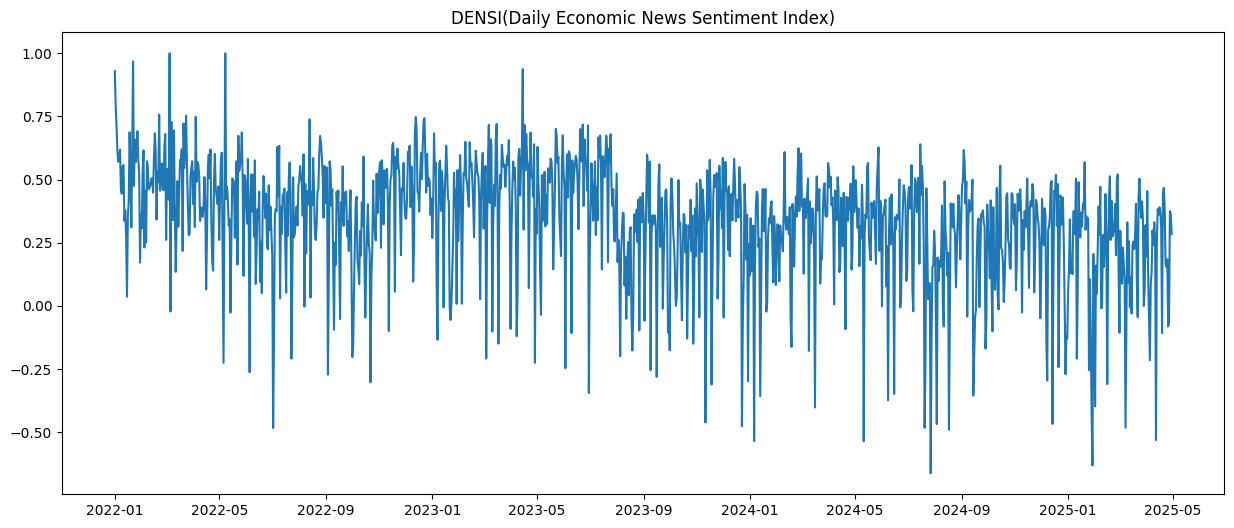

In [89]:
plt.figure(figsize=(15,6))
plt.title("DENSI(Daily Economic News Sentiment Index)")
plt.plot(daily_sentiment_index)

In [84]:
senti_df_m = senti_df.copy()
senti_df_m['month'] = senti_df_m['date'].dt.to_period('M')

filtered_df = senti_df_m[senti_df_m['mapped_label'] != 0]

# 월별 weighted_score 평균으로 monthly_sentiment_index 계산
monthly_sentiment_index = (
    filtered_df.groupby('month')['weighted_score']
    .mean()
    .reset_index(name='monthly_sentiment_index')
)

monthly_sentiment_index['month'] = monthly_sentiment_index['month'].dt.to_timestamp()
monthly_sentiment_index = monthly_sentiment_index.set_index('month')

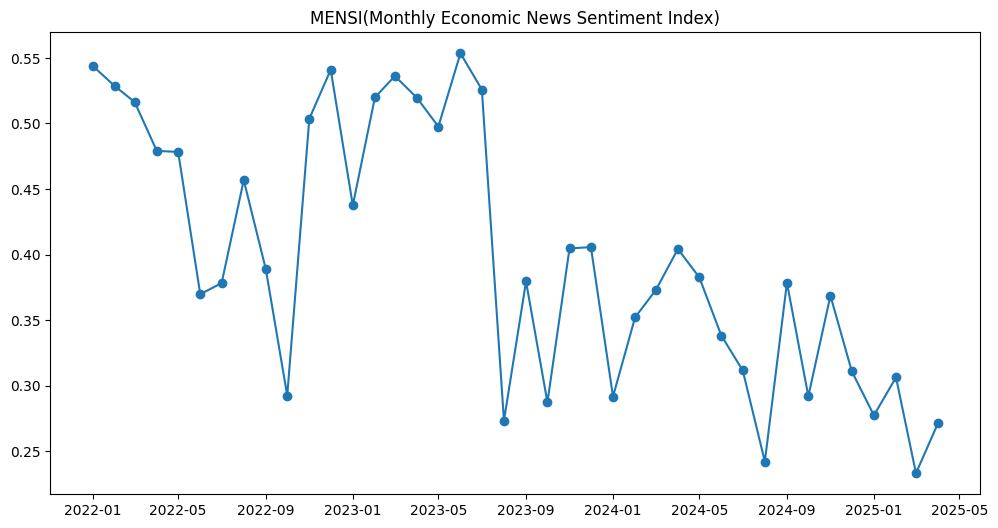

In [88]:
plt.figure(figsize=(12,6))
plt.title("MENSI(Monthly Economic News Sentiment Index)")
plt.plot(monthly_sentiment_index, marker='o')